In [2]:
using DIVAnd
using PyPlot
using PyCall
using Dates
using Statistics
using DelimitedFiles
using NCDatasets
push!(LOAD_PATH, pwd())
using BlueCloudPlankton
using Test
using Pkg

In [3]:
Pkg.update()

   Updating registry at `~/.julia/registries/General`


   Updating git-repo `https://github.com/JuliaRegistries/General.git`


    Fetching: [=============>                           ]  31.2 %

Fetching: [========================================>]  100.0 %Fetching: [===============================>         ]  75.1 %

  Installed JuliaInterpreter ─ v0.7.19
   Updating `~/.julia/environments/v1.4/Project.toml`
 [no changes]
   Updating `~/.julia/environments/v1.4/Manifest.toml`
  [aa1ae85d] ↑ JuliaInterpreter v0.7.17 ⇒ v0.7.19


In [4]:
# Import stuff from cartopy
ccrs = pyimport("cartopy.crs")
gridliner = pyimport("cartopy.mpl.gridliner")
cfeature = pyimport("cartopy.feature")
mticker = pyimport("matplotlib.ticker")
myproj = ccrs.PlateCarree()
coast = cfeature.GSHHSFeature(scale="intermediate");
coast_h = cfeature.GSHHSFeature(scale="high");
cmocean = pyimport("cmocean")

mpl = pyimport("matplotlib");
cartopyticker = pyimport("cartopy.mpl.ticker")
lon_formatter = cartopyticker.LongitudeFormatter()
lat_formatter = cartopyticker.LatitudeFormatter()
mpl.rc("axes", linewidth=2)
mpl.rc("font", weight="light", size=14)

In [5]:
datadir = "../data/"
figdir = "../figures"
resdir = "../results/"
if !isdir(figdir)
    mkdir(figdir)
end
if !isdir(resdir)
    mkdir(resdir)
end

datafile = joinpath(datadir, "data.csv")
@info(isfile(datafile));

longrid = -90.:0.5:40.
latgrid = 30.:0.5:80.

┌ Info: true
└ @ Main In[5]:12


30.0:0.5:80.0

In [6]:
function decorate_global_map(ax, coast)
    PyPlot.grid(linewidth=0.2)
    ax.add_feature(coast, color=".6",
            edgecolor="k", zorder=5)
    ax.set_xticks(-180.:45.5:180.)
    ax.set_yticks(-90.:30:90.)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

end

decorate_global_map (generic function with 1 method)

In [7]:
function decorate_domain_map(ax)
    PyPlot.grid(linewidth=0.2)
    ax.set_xticks(-90.:20.:40.)
    ax.set_yticks(30.:10.:80.)
    ax.set_xlim(-90., 40.)
    ax.set_ylim(30., 80.)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

end

decorate_domain_map (generic function with 1 method)

In [8]:
function decorate_domain_map(ax, coast)
    decorate_domain_map(ax)
    ax.add_feature(coast, color=".6",
            edgecolor="k", zorder=5)
end

decorate_domain_map (generic function with 2 methods)

In [9]:
function plot_results(longrid, latgrid, field, speciesname="", figname="")
    fig = PyPlot.figure(figsize=(10, 10))
    ax = PyPlot.subplot(111, projection=myproj)
    pcm = PyPlot.pcolormesh(longrid, latgrid, field)
    cb = PyPlot.colorbar(pcm, orientation="vertical", shrink=0.35)
    decorate_domain_map(ax)
    title(speciesname)
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
    end
    PyPlot.close()
end

plot_results (generic function with 3 methods)

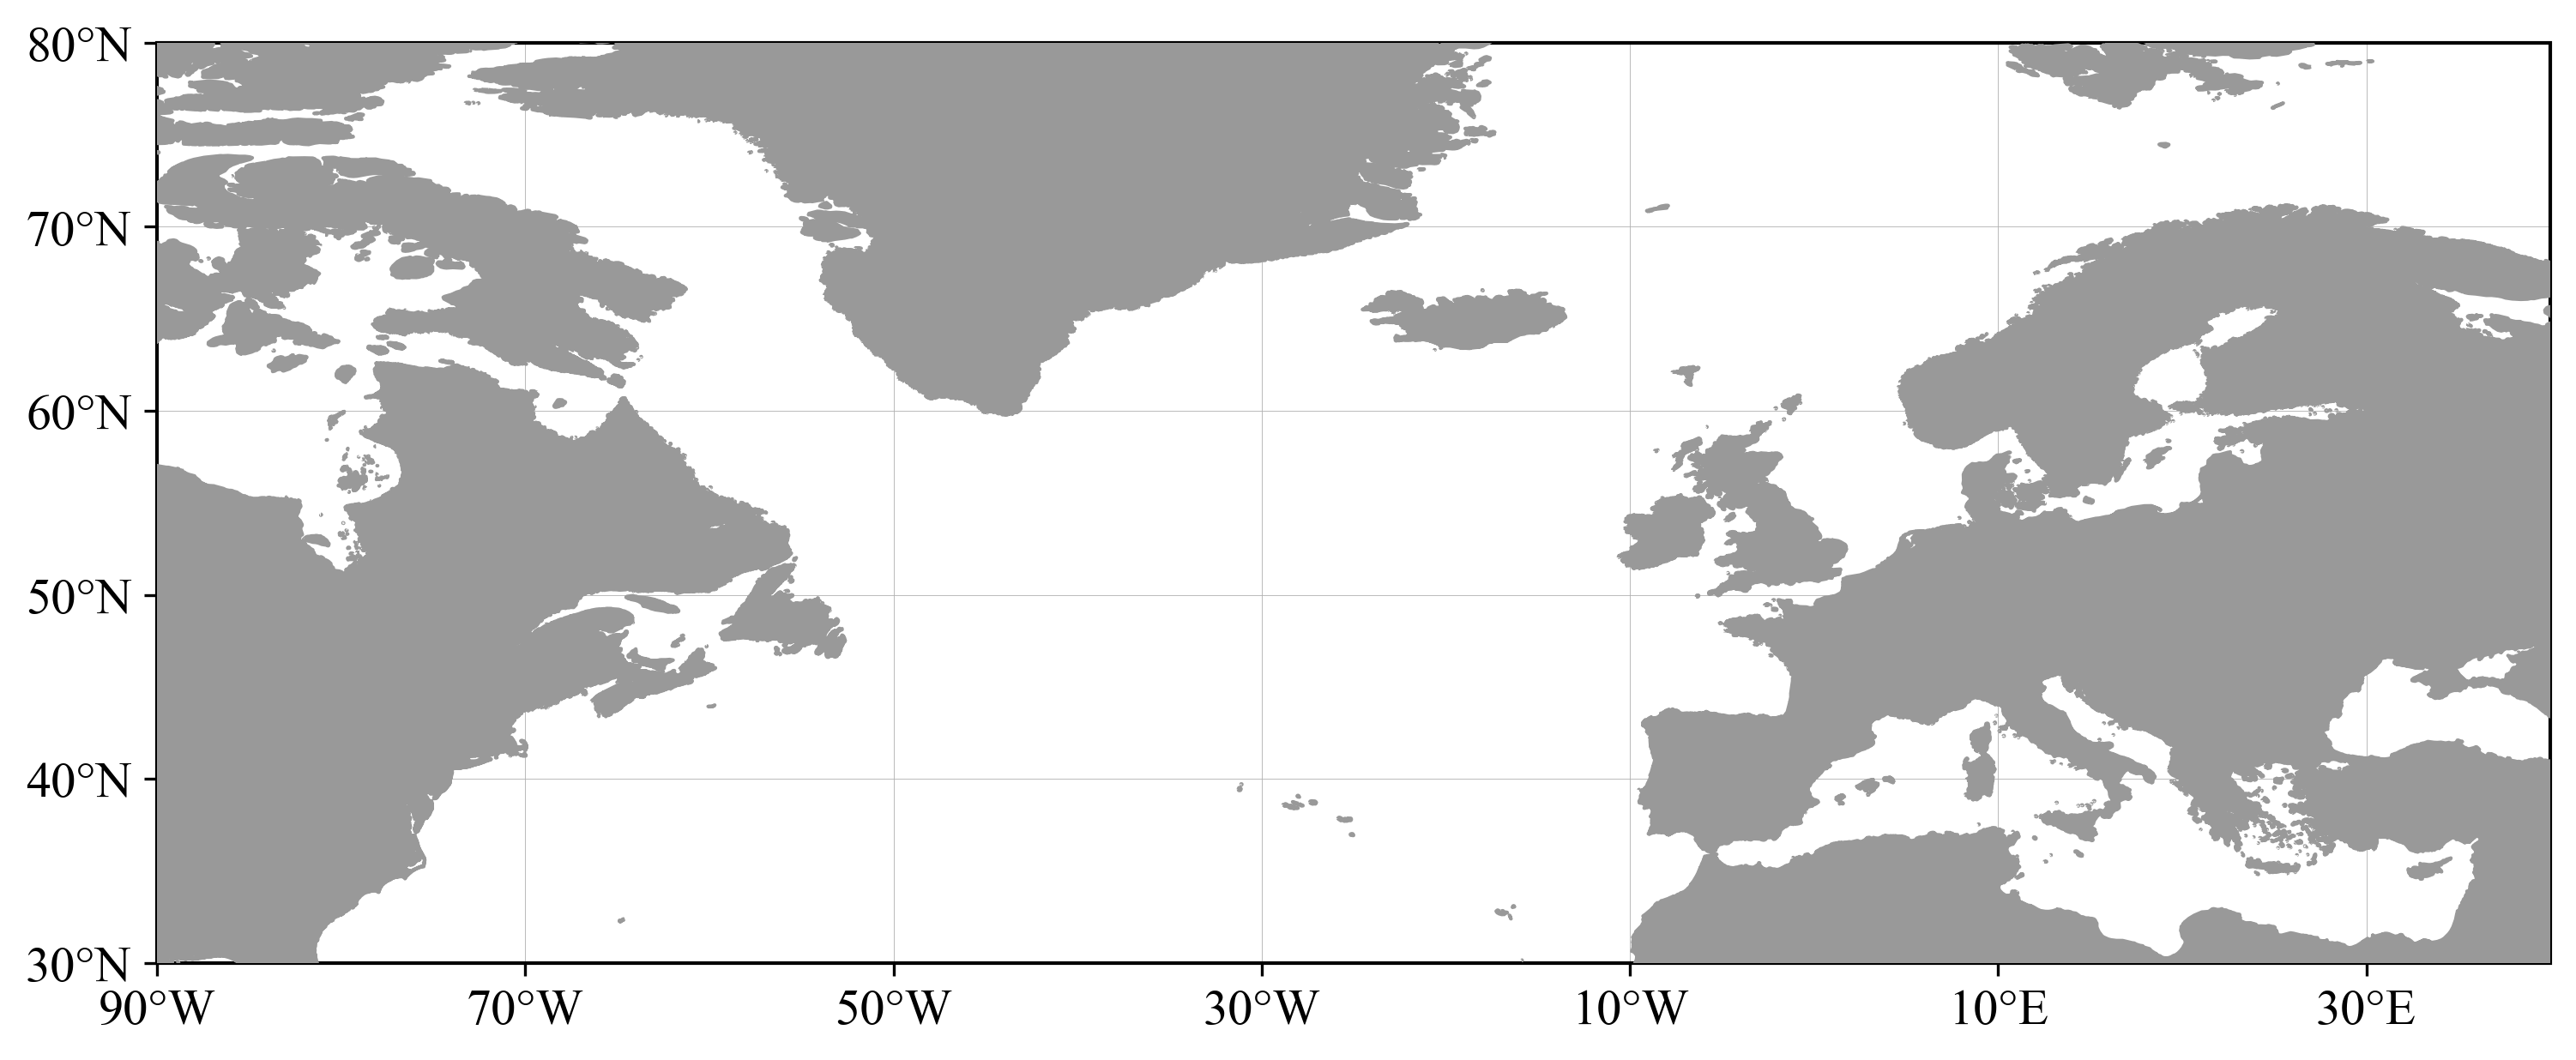

PyObject <cartopy.mpl.feature_artist.FeatureArtist object at 0x7fcfd0d9fc90>

In [10]:
fig = PyPlot.figure(figsize=(12, 8))
ax = subplot(111, projection=myproj)
ax.plot(0., 0., "ko")
decorate_domain_map(ax, coast)

## Read data
We use the function `read_data` that returns the coordinates, abundances and scientific names.

In [11]:
@time lon, lat, dates, abundance, scientificNames = BlueCloudPlankton.read_data(datafile);

  5.655914 seconds (31.05 M allocations: 1.135 GiB, 4.37% gc time)


The file contains 6 species:

In [12]:
namelist = unique(scientificNames)

6-element Array{Any,1}:
 "Metridia lucens"
 "Calanus finmarchicus"
 "Oithona"
 "Temora longicornis"
 "Acartia"
 "Calanus helgolandicus"

## Plots
For this 1st plot we plot only the positions, whatever the abundance.

In [12]:
fig = PyPlot.figure(figsize=(12, 15))
ax = PyPlot.subplot(111, projection=myproj)
ax.plot(lon, lat, "go", markersize=0.2)
decorate_domain_map(ax, coast_h)
PyPlot.savefig(joinpath(figdir, "data_distrib03"), dpi=300, bbox_inches="tight")
PyPlot.show()
PyPlot.close()

### By species

In [13]:
fig = PyPlot.figure(figsize=(15, 11))
for (ii, names) in enumerate(namelist)
    gooddata = findall(scientificNames .== names)
    @info("Found $(length(gooddata)) data points for $(names)")
    ax = PyPlot.subplot(3, 2, ii, projection=myproj)
    ax.plot(0., 0.)
    ax.plot(lon[gooddata], lat[gooddata], "k.", markersize=0.2)
    title("$(names): $(length(gooddata)) data points")
    decorate_domain_map(ax, coast)
end
PyPlot.savefig(joinpath(figdir, "data_species"), dpi=300, bbox_inches="tight")
PyPlot.close()

┌ Info: Found 44353 data points for Metridia lucens
└ @ Main In[13]:4
┌ Info: Found 86486 data points for Calanus finmarchicus
└ @ Main In[13]:4
┌ Info: Found 66761 data points for Oithona
└ @ Main In[13]:4
┌ Info: Found 43416 data points for Temora longicornis
└ @ Main In[13]:4
┌ Info: Found 66328 data points for Acartia
└ @ Main In[13]:4
┌ Info: Found 59034 data points for Calanus helgolandicus
└ @ Main In[13]:4


### Histogram
#### Time

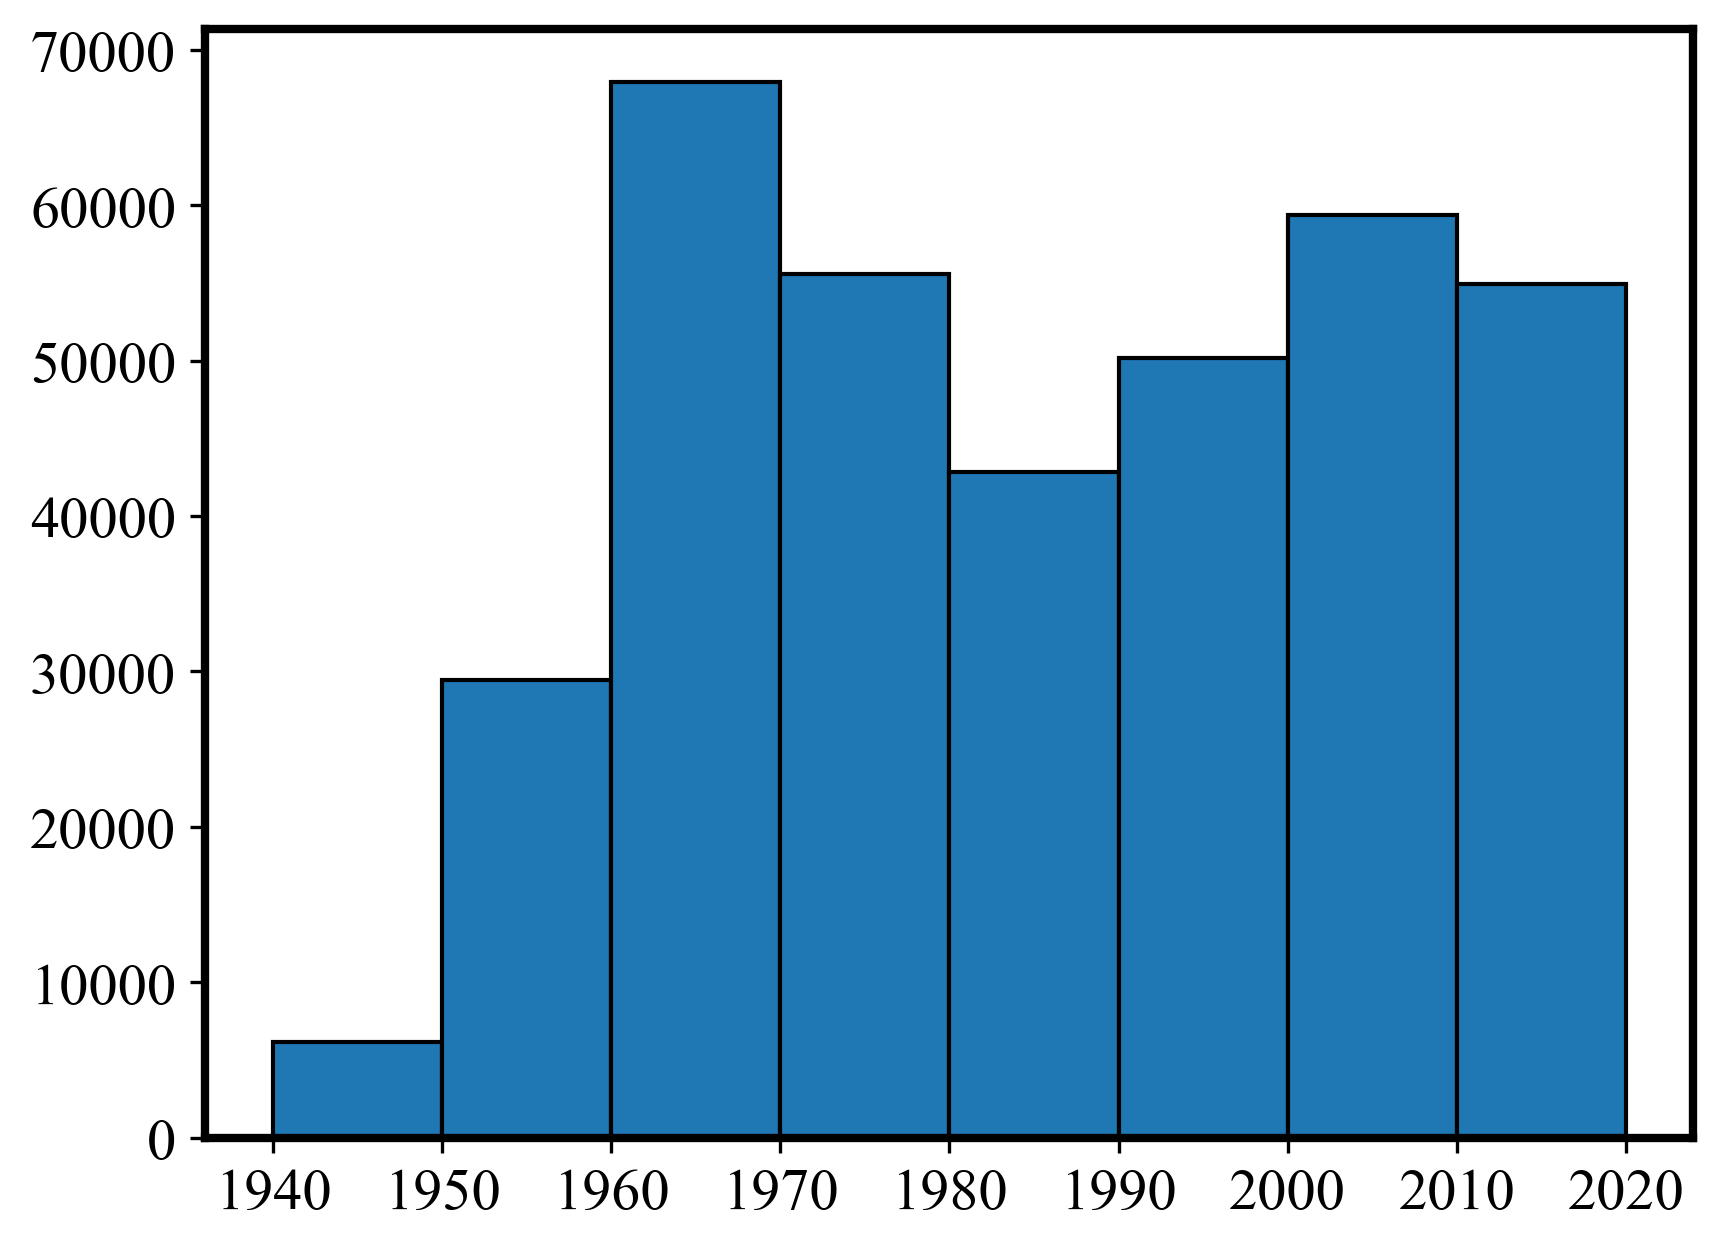

(706743.0, 738885.0)

In [14]:
datebins = [DateTime(yy, 1, 1) for yy = 1940:10:2020];
datenumbins = Dates.value.(convert.(Dates.Day, datebins .- DateTime(1, 1, 1)))
ax = PyPlot.subplot(111)
PyPlot.hist(dates, datenumbins, ec="black")
print(ax.get_xlim())
PyPlot.savefig(joinpath(figdir, "time_histogram"), dpi=300, bbox_inches="tight")

#### Values (abundances)
It can be interesting to look at the distributions for the different species. 

In [23]:
namelist

6-element Array{Any,1}:
 "Metridia lucens"
 "Calanus finmarchicus"
 "Oithona"
 "Temora longicornis"
 "Acartia"
 "Calanus helgolandicus"

In [30]:
gooddata = findall(scientificNames .== namelist[5])
round(abundance[gooddata][2], digits=2)

16.67

In [31]:
fig = PyPlot.figure(figsize=(12, 8))
for (ii, names) in enumerate(namelist)
    gooddata = findall(scientificNames .== names)
    @info("Found $(length(gooddata)) data points for $(names)")
    PyPlot.hist(abundance[gooddata], bins=20)
    title("$(names) (max = $(round(maximum(abundance[gooddata]), digits=2)))");
    PyPlot.savefig(joinpath(figdir, "histogram_$(names)"), dpi=300, bbox_inches="tight")
    PyPlot.close()
end

┌ Info: Found 44353 data points for Metridia lucens
└ @ Main In[31]:4
┌ Info: Found 86486 data points for Calanus finmarchicus
└ @ Main In[31]:4
┌ Info: Found 66761 data points for Oithona
└ @ Main In[31]:4
┌ Info: Found 43416 data points for Temora longicornis
└ @ Main In[31]:4
┌ Info: Found 66328 data points for Acartia
└ @ Main In[31]:4
┌ Info: Found 59034 data points for Calanus helgolandicus
└ @ Main In[31]:4


## Bathymetry
For the bathymetry, considering the size of the domain, we will work with the GEBCO bathymetry with a resolution decreased 16 times     
(i.e. 30 secondes times 16 equal = 8 minutes).

In [15]:
bathname = joinpath(datadir, "gebco_30sec_16.nc")
if !isfile(bathname)
    @info("Download bathymetry")
    download("https://dox.ulg.ac.be/index.php/s/U0pqyXhcQrXjEUX/download",bathname)
else
    @info("Bathymetry file already downloaded")
end

┌ Info: Bathymetry file already downloaded
└ @ Main In[15]:6


### Bathymetry reading
We consider the full bathymetry and will consider if there is a need to remove the Mediterranean Sea.

In [16]:
bx, by, b = load_bath(bathname, true, longrid, latgrid);

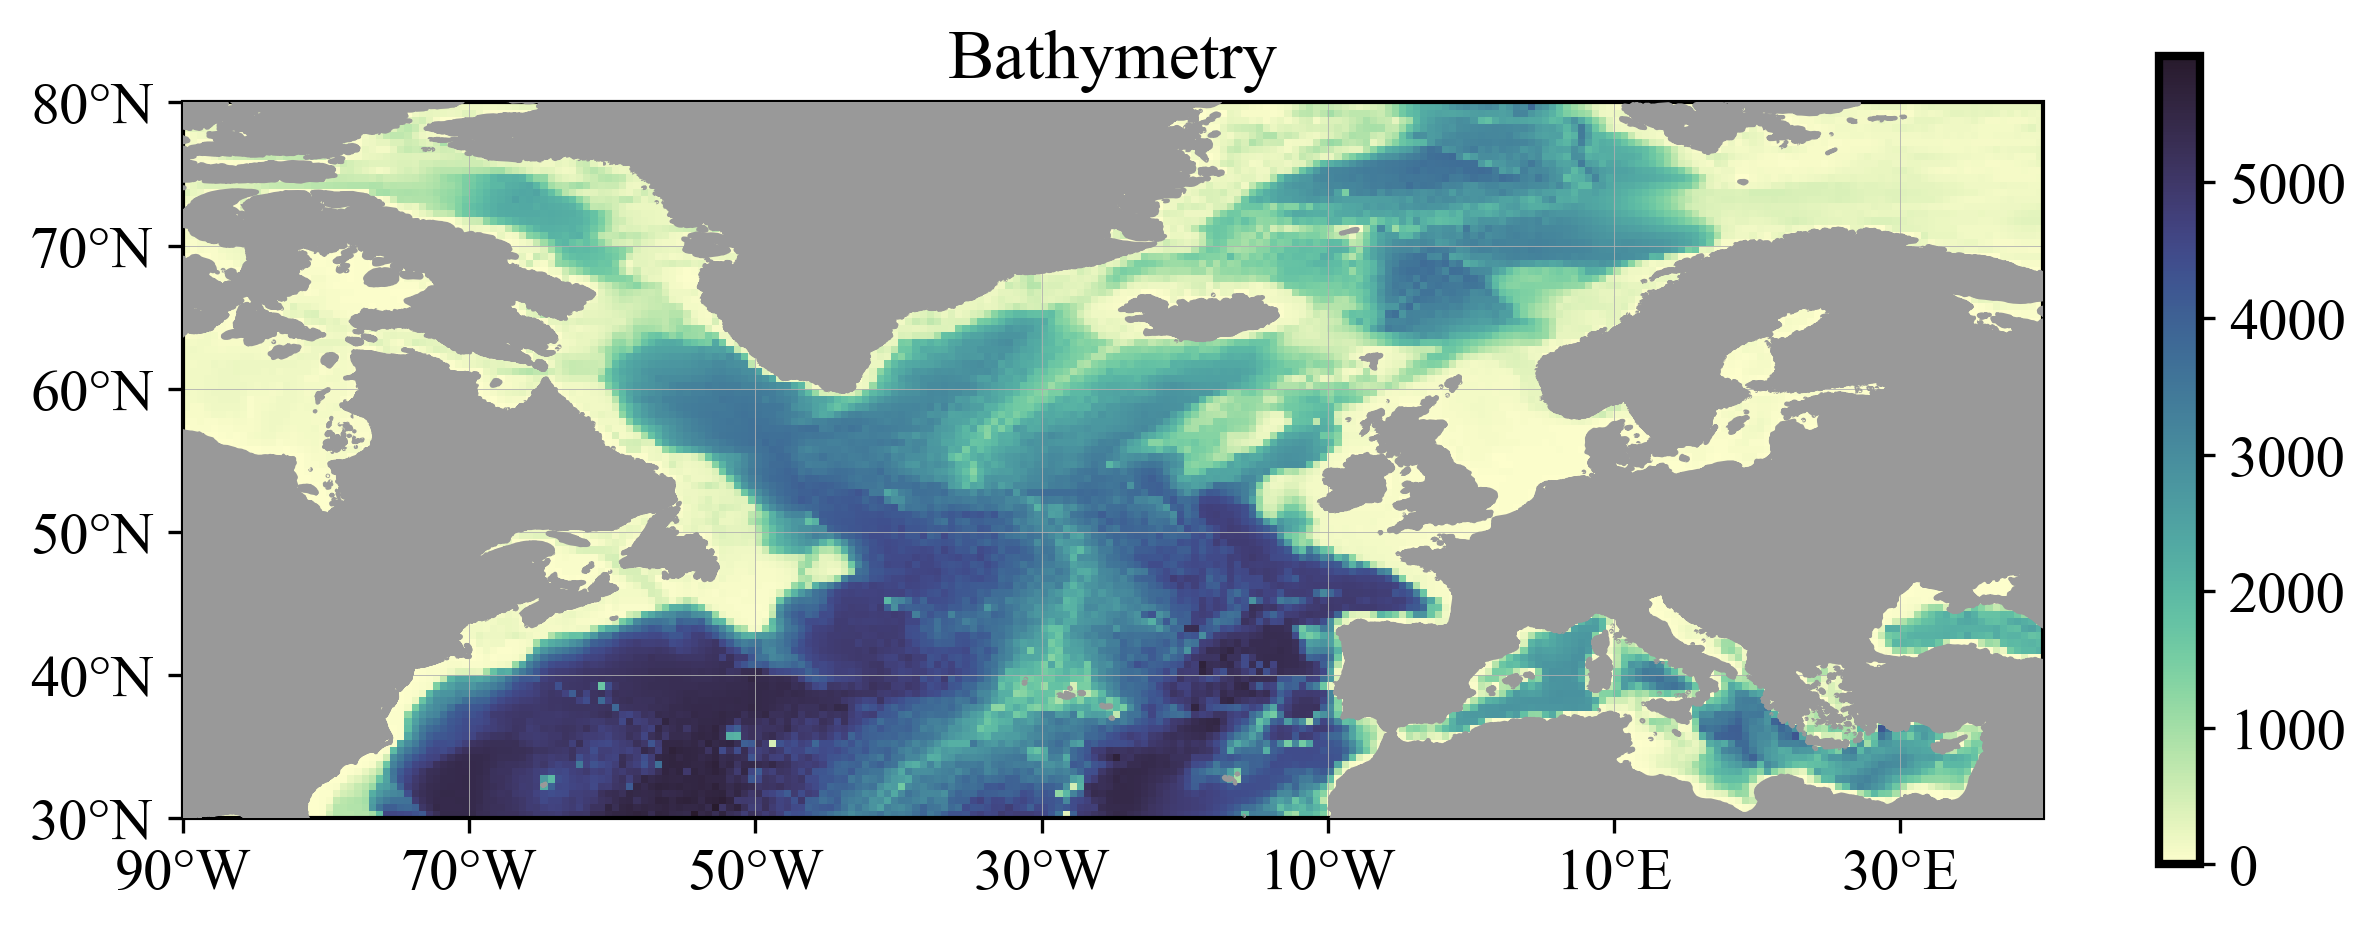

In [17]:
fig = PyPlot.figure(figsize=(10, 10))
ax = PyPlot.subplot(111, projection=myproj)
pcm = ax.pcolor(bx, by, b', cmap=cmocean.cm.deep, vmin=0.); 
colorbar(pcm, orientation="vertical", shrink=0.35)
decorate_domain_map(ax, coast)
PyPlot.title("Bathymetry")
PyPlot.savefig(joinpath(figdir, "domain_bathymetry2"), dpi=300, bbox_inches="tight")
PyPlot.show()
#PyPlot.close()

### Metrics

In [18]:
_, (pm,pn), (xi,yi) = DIVAnd.DIVAnd_rectdom(longrid, latgrid);

### Land-sea mask

In [19]:
xmask, ymask, mmask = load_mask(bathname, true, longrid, latgrid, 0.0);

In [20]:
fig = PyPlot.figure(figsize=(10, 10))
ax = PyPlot.subplot(111, projection=myproj)
pcm = ax.pcolor(bx, by, transpose(mmask), cmap=PyPlot.cm.binary_r); 
decorate_domain_map(ax)
PyPlot.title("Land-sea mask")
PyPlot.savefig(joinpath(figdir, "domain_landsea_mask2b"), dpi=300, bbox_inches="tight")
PyPlot.close()

## DIVAnd interpolation
### Set parameters

In [21]:
function create_nc_results(filename::String, lons, lats, field, len, epsilon2, speciesname=""; valex=-999.9)
    Dataset(filename, "c") do ds

        # Dimensions
        ds.dim["lon"] = length(lons)
        ds.dim["lat"] = length(lats)
        ds.dim["time"] = Inf # unlimited dimension

        # Declare variables
        ncfield = defVar(ds, "abundance", Float64, ("lon", "lat"))
        ncfield.attrib["missing_value"] = Float64(valex)
        ncfield.attrib["_FillValue"] = Float64(valex)
        ncfield.attrib["long_name"] = "interpolated abundance of $(speciesname)"
        ncfield.attrib["units"] = "ind/m3"

        nctime = defVar(ds,"time", Float32, ("time",))
        nctime.attrib["missing_value"] = Float32(valex)
        nctime.attrib["units"] = "seconds since 1981-01-01 00:00:00"
        nctime.attrib["time"] = "time"

        nclon = defVar(ds,"lon", Float32, ("lon",))
        nclon.attrib["missing_value"] = Float32(valex)
        nclon.attrib["_FillValue"] = Float32(valex)
        nclon.attrib["units"] = "degrees East"
        nclon.attrib["lon"] = "longitude"

        nclat = defVar(ds,"lat", Float32, ("lat",))
        nclat.attrib["missing_value"] = Float32(valex)
        nclat.attrib["_FillValue"] = Float32(valex)
        nclat.attrib["units"] = "degrees North"
        nclat.attrib["lat"] = "latitude"

        # Global attributes
        ds.attrib["institution"] = "GHER - University of Liege"
        ds.attrib["title"] = "Interpolated field of $(speciesname)"
        ds.attrib["comment"] = "Original data prepared by VLIZ"
        ds.attrib["author"] = "C. Troupin (ctroupin@uliege), A. Barth (a.barth@uliege.be)"
        ds.attrib["tool"] = "create_nc_results.jl"
        ds.attrib["institution_url"] = "http://labos.ulg.ac.be/gher/"
        ds.attrib["institution_logo_url"] = "http://gher-diva.phys.ulg.ac.be/Images/gher-logo.png"
        ds.attrib["Correlation length"] = "$(len)"
        ds.attrib["Noise-to-signal ratio"] = "$(epsilon2)"

        # Define variables
        ncfield[:,:] = field
        nclon[:] = lons
        nclat[:] = lats;

    end
end;

In [30]:
len = 5.;
epsilon2 = 10.
llon, llat = ndgrid(longrid, latgrid);

### No transformation applied to data

In [27]:
for (ii, names) in enumerate(namelist)
    @info("Working on species $(names)");
    gooddata = findall(scientificNames .== names)
    field, s = DIVAndrun(mmask, (pm, pn), (llon, llat), 
        (lon[gooddata], lat[gooddata]), abundance[gooddata] .- mean(abundance[gooddata]), 
        (len, len), epsilon2);
    figname = joinpath(figdir, "$(replace(namelist[ii], " "=>"_"))_interp_V4")
    ncfilename = joinpath(resdir, "$(replace(namelist[ii], " "=>"_"))_interp_V4.nc")
    
    # Make plot
    @info(size(llon))
    #plot_results(longrid, latgrid, field .+ mean(abundance[gooddata]), 
    #    namelist[ii], joinpath(figdir, fname))
    fig = PyPlot.figure(figsize=(10, 10))
    ax = PyPlot.subplot(111, projection=myproj)
    pcm = ax.pcolor(longrid, latgrid, field' .+ mean(abundance[gooddata]), cmap=cmocean.cm.thermal, vmin=0.); 
    cb = PyPlot.colorbar(pcm, orientation="vertical", shrink=0.35)
    decorate_domain_map(ax, coast)
    title(names)
    
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
    end
    # PyPlot.show()
    PyPlot.close()

    # Create netCDF
    create_nc_results(ncfilename, collect(longrid), collect(latgrid), field, len, epsilon2, names)
    @info("Saved results in file $(ncfilename)")
end 

┌ Info: Working on species Metridia lucens
└ @ Main In[27]:2
┌ Info: (261, 101)
└ @ Main In[27]:11
┌ Info: Saved results in file ../results/Metridia_lucens_interp_V4.nc
└ @ Main In[27]:29
┌ Info: Working on species Calanus finmarchicus
└ @ Main In[27]:2
┌ Info: (261, 101)
└ @ Main In[27]:11
┌ Info: Saved results in file ../results/Calanus_finmarchicus_interp_V4.nc
└ @ Main In[27]:29
┌ Info: Working on species Oithona
└ @ Main In[27]:2
┌ Info: (261, 101)
└ @ Main In[27]:11
┌ Info: Saved results in file ../results/Oithona_interp_V4.nc
└ @ Main In[27]:29
┌ Info: Working on species Temora longicornis
└ @ Main In[27]:2
┌ Info: (261, 101)
└ @ Main In[27]:11
┌ Info: Saved results in file ../results/Temora_longicornis_interp_V4.nc
└ @ Main In[27]:29
┌ Info: Working on species Acartia
└ @ Main In[27]:2
┌ Info: (261, 101)
└ @ Main In[27]:11
┌ Info: Saved results in file ../results/Acartia_interp_V4.nc
└ @ Main In[27]:29
┌ Info: Working on species Calanus helgolandicus
└ @ Main In[27]:2
┌ Info: (

### Logarithm transformation

In [31]:
for (ii, names) in enumerate(namelist)
    @info("Working on species $(names)");
    gooddata = findall(scientificNames .== names)
    logabundance = log10.(abundance[gooddata])
    
    field, s = DIVAndrun(mmask, (pm, pn), (llon, llat), 
        (lon[gooddata], lat[gooddata]), logabundance .- mean(logabundance), 
        (len, len), epsilon2);
    figname = joinpath(figdir, "$(replace(namelist[ii], " "=>"_"))_interp_log_V6")
    ncfilename = joinpath(resdir, "$(replace(namelist[ii], " "=>"_"))_interp_log_V6.nc")
    
    # Make plot
    @info(size(llon))
    #plot_results(longrid, latgrid, field .+ mean(abundance[gooddata]), 
    #    namelist[ii], joinpath(figdir, fname))
    fig = PyPlot.figure(figsize=(10, 10))
    ax = PyPlot.subplot(111, projection=myproj)
    pcm = ax.pcolor(longrid, latgrid, field' .+ mean(logabundance), cmap=cmocean.cm.thermal, vmin=0.); 
    cb = PyPlot.colorbar(pcm, orientation="vertical", shrink=0.35)
    decorate_domain_map(ax, coast)
    title(names)
    
    if length(figname) > 0
        PyPlot.savefig(figname, dpi=300, bbox_inches="tight")
    end
    # PyPlot.show()
    PyPlot.close()

    # Create netCDF
    create_nc_results(ncfilename, collect(longrid), collect(latgrid), field, len, epsilon2, names)
    @info("Saved results in file $(ncfilename)")
end 

┌ Info: Working on species Metridia lucens
└ @ Main In[31]:2
┌ Warning: Observations equal to NaN: 128
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_obs.jl:45
┌ Info: (261, 101)
└ @ Main In[31]:13
┌ Info: Saved results in file ../results/Metridia_lucens_interp_log_V6.nc
└ @ Main In[31]:31
┌ Info: Working on species Calanus finmarchicus
└ @ Main In[31]:2
┌ Warning: Observations equal to NaN: 99
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_obs.jl:45
┌ Info: (261, 101)
└ @ Main In[31]:13
┌ Info: Saved results in file ../results/Calanus_finmarchicus_interp_log_V6.nc
└ @ Main In[31]:31
┌ Info: Working on species Oithona
└ @ Main In[31]:2
┌ Warning: Observations equal to NaN: 5047
└ @ DIVAnd /home/ctroupin/.julia/packages/DIVAnd/ZfEqh/src/DIVAnd_obs.jl:45
┌ Info: (261, 101)
└ @ Main In[31]:13
┌ Info: Saved results in file ../results/Oithona_interp_log_V6.nc
└ @ Main In[31]:31
┌ Info: Working on species Temora longicornis
└ @ Main In[31]:2
┌ Warning: O